In [1]:
import functools
from tqdm import tqdm
import random
import copy

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10

from sparse_net import SparseNet
import hyperparameters

In [2]:
# CONFIG
dataset = "mnist"
continual = True
config = hyperparameters.mnist
config["data_dir"] = "/home/ekarais/mcil/data/"
config["num_epochs"] = 5
config["network_hyperparameters"]["k"] = 10
config["network_hyperparameters"]["n"] = 150
config["continual_batch_size"] = 128
config["continual_learning_rate"] = 1e-5
config["continual_num_classes"] = 5

In [3]:
def get_continual_split(dataset, num_classes=1):
    train_dataset = torch.utils.data.Subset(dataset, [idx for idx, label in enumerate(dataset.train_labels) if label in range(10-num_classes)])
    continual_loaders = []
    for class_idx in range(10-num_classes, 10):
        marginal_dataset = torch.utils.data.Subset(dataset, [idx for idx, label in enumerate(dataset.train_labels) if label == class_idx])
        continual_loaders.append(DataLoader(marginal_dataset, batch_size=config["continual_batch_size"], shuffle=True))
    return train_dataset, continual_loaders

def contrastive_divergence(logits, labels):
    """
    TODO: Try out Perceptron analogous rule that only updates after mistakes
    """
    num_samples = labels.shape[0]
    random_idc = torch.randint(0, 10, (num_samples,))
    return torch.sum(logits[range(num_samples), random_idc]) - torch.sum(logits[range(num_samples), labels])
    """
    for i in range(labels.shape[0]):
        pred = torch.argmax(logits[i]).item()
        if pred == labels[i]:
            random_idx = random.randint(0, 9)
            loss += logits[random_idx] - logits[labels[i]]
        else:
            loss += logits[pred] - logits[labels[i]]
    """

# Define dataset and dataloaders

In [4]:
if dataset == "mnist":
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_dataset = MNIST(config["data_dir"], train=True, download=True, transform=transform)
    test_dataset = MNIST(config["data_dir"], train=False, download=True, transform=transform)

if dataset == "cifar10":
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

if continual:
    train_dataset, continual_loaders = get_continual_split(train_dataset, num_classes=config["continual_num_classes"])

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
fe_loader = DataLoader(train_dataset, batch_size=config["first_epoch_batch_size"], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config["test_batch_size"], shuffle=True)

/home/ekarais/miniconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


# Create neural network, optimizer, etc.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SparseNet(**config["network_hyperparameters"]).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=config["learning_rate"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config["lr_scheduler_params"]["step_size"], gamma=config["lr_scheduler_params"]["gamma"])
criterion = F.cross_entropy

# Training loop

In [6]:
accuracies, losses = [], [] * 10

for e in range(config["num_epochs"]):
    
    # Train
    model.train()

    loader = train_loader if e > 0 else fe_loader

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

    # Test
    model.eval()
    loss, correct = 0, 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss += criterion(y_pred, y)
        pred = y_pred.max(1, keepdim=True)[1]
        correct += pred.eq(y.view_as(pred)).sum().item()
    
    scheduler.step()

    # Print results
    losses.append(loss.item() / len(test_loader))
    accuracies.append(correct / len(test_dataset))

    print(f"Epoch {e+1}: Accuracy = {accuracies[-1]:.4f}, loss = {losses[-1]:.4f}")

Epoch 1: Accuracy = 0.5066, loss = 4.5004
Epoch 2: Accuracy = 0.5091, loss = 4.8103
Epoch 3: Accuracy = 0.5088, loss = 5.0033
Epoch 4: Accuracy = 0.5091, loss = 5.0353
Epoch 5: Accuracy = 0.5090, loss = 5.0958


# Continual learning

In [7]:
if continual:
    model_cp = copy.deepcopy(model)
    optimizer_cp = torch.optim.SGD(model_cp.parameters(), lr=config["continual_learning_rate"])

    # Freeze everything except last layer
    for param in model_cp.cnnSdr:
        param.requires_grad = False

    """
    for param in model_cp.linearSdr:
        param.requires_grad = False
    """
    
    for e, loader in enumerate(continual_loaders):
        
        # Train
        model_cp.train()

        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer_cp.zero_grad()
            y_pred = model_cp(x)
            loss = contrastive_divergence(y_pred, y)
            loss.backward()
            optimizer_cp.step()

        # Test
        model_cp.eval()
        loss, correct = 0, 0
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            optimizer_cp.zero_grad()
            y_pred = model_cp(x)
            loss += criterion(y_pred, y)
            pred = y_pred.max(1, keepdim=True)[1]
            correct += pred.eq(y.view_as(pred)).sum().item()
        
        #scheduler.step()

        # Print results
        losses.append(loss.item() / len(test_loader))
        accuracies.append(correct / len(test_dataset))
        print(f"Epoch {e+6}: Accuracy = {accuracies[-1]:.4f}, loss = {losses[-1]:.4f}")

Epoch 6: Accuracy = 0.5158, loss = 4.1279
Epoch 7: Accuracy = 0.5299, loss = 3.3610
Epoch 8: Accuracy = 0.5565, loss = 2.7076
Epoch 9: Accuracy = 0.5230, loss = 2.3315
Epoch 10: Accuracy = 0.2301, loss = 5.8337


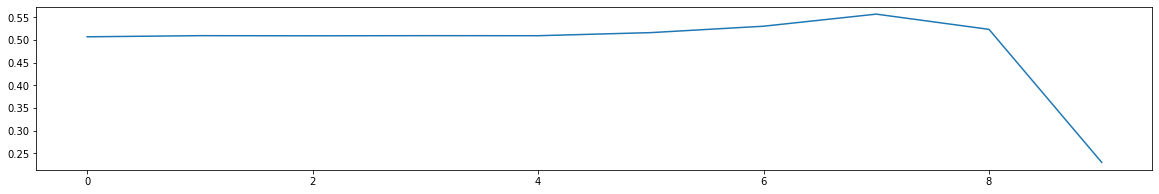

In [12]:
plt.plot(accuracies)
plt.show()

k/n = 0.5, cbatch_size = 64, num_classes=5  
- Epoch 1: Accuracy = 0.5064, loss = 5.0463
- Epoch 2: Accuracy = 0.5102, loss = 5.0519
- Epoch 3: Accuracy = 0.5100, loss = 5.0688
- Epoch 4: Accuracy = 0.5103, loss = 5.1469
- Epoch 5: Accuracy = 0.5102, loss = 5.1847
- Epoch 6: Accuracy = 0.3469, loss = 5.0968
- Epoch 7: Accuracy = 0.2971, loss = 3.9103
- Epoch 8: Accuracy = 0.1926, loss = 4.3945
- Epoch 9: Accuracy = 0.1632, loss = 3.4623
- Epoch 10: Accuracy = 0.2637, loss = 2.6053

k/n = 0.1, cbatch_size = 64, num_classes=5
- Epoch 1: Accuracy = 0.5082, loss = 4.3091
- Epoch 2: Accuracy = 0.5088, loss = 4.4989
- Epoch 3: Accuracy = 0.5093, loss = 4.6351
- Epoch 4: Accuracy = 0.5090, loss = 4.6894
- Epoch 5: Accuracy = 0.5093, loss = 4.7322
- Epoch 6: Accuracy = 0.3744, loss = 4.1252
- Epoch 7: Accuracy = 0.2844, loss = 4.0484
- Epoch 8: Accuracy = 0.1992, loss = 4.5525
- Epoch 9: Accuracy = 0.1762, loss = 3.8198
- Epoch 10: Accuracy = 0.1911, loss = 3.5139

k/n = 0.1, cbatch_size = 1000, num_classes=5
- Epoch 1: Accuracy = 0.5099, loss = 4.9009
- Epoch 2: Accuracy = 0.5102, loss = 4.9802
- Epoch 3: Accuracy = 0.5102, loss = 5.0313
- Epoch 4: Accuracy = 0.5104, loss = 5.0584
- Epoch 5: Accuracy = 0.5101, loss = 5.0824
- Epoch 6: Accuracy = 0.4992, loss = 3.6592
- Epoch 7: Accuracy = 0.5080, loss = 2.5587
- Epoch 8: Accuracy = 0.5078, loss = 2.1479
- Epoch 9: Accuracy = 0.5079, loss = 1.8950
- Epoch 10: Accuracy = 0.5062, loss = 1.7333

k/n = 0.1, cbatch_size = 2000, num_classes=5
- Epoch 1: Accuracy = 0.5082, loss = 4.6018
- Epoch 2: Accuracy = 0.5097, loss = 4.7513
- Epoch 3: Accuracy = 0.5104, loss = 4.8468
- Epoch 4: Accuracy = 0.5101, loss = 4.8978
- Epoch 5: Accuracy = 0.5101, loss = 4.9481
- Epoch 6: Accuracy = 0.4510, loss = 3.5416
- Epoch 7: Accuracy = 0.4117, loss = 3.4274
- Epoch 8: Accuracy = 0.2813, loss = 2.4435
- Epoch 9: Accuracy = 0.2189, loss = 4.2437
- Epoch 10: Accuracy = 0.2096, loss = 2.9414

k/n = 0.1, cbatch_size = 1000 (frozen except final layer), num_classes=5
- Epoch 1: Accuracy = 0.5085, loss = 4.7954
- Epoch 2: Accuracy = 0.5094, loss = 4.7900
- Epoch 3: Accuracy = 0.5090, loss = 4.7555
- Epoch 4: Accuracy = 0.5090, loss = 4.7553
- Epoch 5: Accuracy = 0.5087, loss = 4.8191
- Epoch 6: Accuracy = 0.4866, loss = 3.1440
- Epoch 7: Accuracy = 0.5011, loss = 2.4275
- Epoch 8: Accuracy = 0.4972, loss = 1.9922
- Epoch 9: Accuracy = 0.4980, loss = 1.7820
- Epoch 10: Accuracy = 0.4951, loss = 1.6539

### Takeaways
- Reducing k/n alone does not seem to mitigate CF.
- Once in the continual learning (CL) regime, the loss and accuracy start dropping together, which is unusual. 
- By strongly increasing the CL regime batch size (effectively reducing the number of parameter updates), we can bring down the loss significantly more (3.5 to 1.7) and suffer no CF, but the accuracy does not improve either. This benefit seems to be lost if we increase CL regime batch size even further.
- Freezing everything except the final hidden layer only helps a little, potentially not at all.
- All findings above are based on single executions, better re-run experiments multiple times for certainty.

### Next steps
- Reduce k/n even further by increasing n a lot, then only freeze the cnn and use large batch size => does not change anything. I realized that this is because the final decision layer is densely updated...
- Use contrastive divergence ALSO during i.i.d training.
- Use contrastive divergence on dense network, compare results
- plot confusion matrix
- compute activation overlaps somehow
- Set number of continual learning classes to 1

k/n = 0.1, cbatch_size = 1000 (frozen cnn + contrastive divergence during CL), num_classes=5
- Epoch 1: Accuracy = 0.5093, loss = 4.3138
- Epoch 2: Accuracy = 0.5096, loss = 4.5218
- Epoch 3: Accuracy = 0.5100, loss = 4.6063
- Epoch 4: Accuracy = 0.5101, loss = 4.6912
- Epoch 5: Accuracy = 0.5101, loss = 4.7616
- Epoch 6: Accuracy = 0.5070, loss = 4.1733
- Epoch 7: Accuracy = 0.5109, loss = 3.2822
- Epoch 8: Accuracy = 0.5085, loss = 2.4707
- Epoch 9: Accuracy = 0.5075, loss = 1.8425
- Epoch 10: Accuracy = 0.5175, loss = **1.3504**

k/n = 0.1, cbatch_size = 512 (frozen cnn + contrastive divergence during CL), num_classes=5
- Epoch 1: Accuracy = 0.5091, loss = 4.1679
- Epoch 2: Accuracy = 0.5096, loss = 4.3857
- Epoch 3: Accuracy = 0.5098, loss = 4.4505
- Epoch 4: Accuracy = 0.5100, loss = 4.5395
- Epoch 5: Accuracy = 0.5102, loss = 4.6221
- Epoch 6: Accuracy = 0.5095, loss = 4.4327
- Epoch 7: Accuracy = 0.5563, loss = 4.0115
- Epoch 8: Accuracy = 0.5821, loss = 3.4107
- Epoch 9: Accuracy = 0.2740, loss = 4.4475
- Epoch 10: Accuracy = 0.1011, loss = 13.0413


k/n = 0.1, cbatch_size = 256 (frozen cnn + contrastive divergence during CL), num_classes=5
- Epoch 1: Accuracy = 0.5083, loss = 4.5104
- Epoch 2: Accuracy = 0.5101, loss = 4.6225
- Epoch 3: Accuracy = 0.5104, loss = 4.7108
- Epoch 4: Accuracy = 0.5103, loss = 4.7927
- Epoch 5: Accuracy = 0.5103, loss = 4.8529
- Epoch 6: Accuracy = 0.5122, loss = 4.3171
- Epoch 7: Accuracy = 0.5396, loss = 3.3979
- Epoch 8: Accuracy = 0.5387, loss = 2.5908
- Epoch 9: Accuracy = 0.5651, loss = 1.7700
- Epoch 10: Accuracy = 0.5807, loss = 1.3371

k/n = 0.1, cbatch_size = 128 (frozen cnn + contrastive divergence during CL), num_classes=5
- Epoch 1: Accuracy = 0.5086, loss = 4.0126
- Epoch 2: Accuracy = 0.5089, loss = 4.2935
- Epoch 6: Accuracy = 0.5077, loss = 4.1278
- Epoch 7: Accuracy = 0.5084, loss = 3.4736
- Epoch 8: Accuracy = 0.5108, loss = 2.5882
- Epoch 9: Accuracy = 0.5568, loss = 1.7713
- Epoch 10: Accuracy = 0.6177, loss = 1.1573

k/n = 0.1, cbatch_size = 64 (frozen cnn + contrastive divergence during CL), num_classes=5
- Epoch 1: Accuracy = 0.5087, loss = 4.3742
- Epoch 2: Accuracy = 0.5106, loss = 4.4751
- Epoch 3: Accuracy = 0.5099, loss = 4.6011
- Epoch 4: Accuracy = 0.5099, loss = 4.6098
- Epoch 5: Accuracy = 0.5097, loss = 4.6192
- Epoch 6: Accuracy = 0.5080, loss = 4.0452
- Epoch 7: Accuracy = 0.5397, loss = 3.3654
- Epoch 8: Accuracy = 0.5884, loss = 2.5469
- Epoch 9: Accuracy = 0.6041, loss = 1.7788
- Epoch 10: Accuracy = 0.5887, loss = 1.2069

# Computing hidden layer activations

In [9]:
# Code for saving hidden layer activations
hidden_activations = {"cnn" : [], "linear" : []}

def get_hidden_activations(name):
    def hook(model, input, output):
        hidden_activations[name] = output.detach()
    return hook

model.cnnSdr.register_forward_hook(get_hidden_activations("cnn"))
model.linearSdr.register_forward_hook(get_hidden_activations("linear"))

# Final evaluation 
model.eval()
loss, correct = 0, 0
batch_hidden_activations = []
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    y_pred = model(x)
    loss += criterion(y_pred, y)
    pred = y_pred.max(1, keepdim=True)[1]
    correct += pred.eq(y.view_as(pred)).sum().item()
    batch_hidden_activations.append((hidden_activations.copy(), y))

# Print results
loss /= len(test_loader)
accuracy = correct / len(test_dataset)
print(f"Final evaluation. Accuracy = {accuracy:.3f}, loss = {loss:.6f}")

Final evaluation. Accuracy = 0.509, loss = 5.095767


# Group hidden activations by label

In [10]:
all_hidden_activations = functools.reduce(lambda a, b: torch.cat((a, b)), [item[0]["linear"] for item in batch_hidden_activations]).cpu().numpy()
all_labels = functools.reduce(lambda a, b: torch.cat((a, b)), [item[1] for item in batch_hidden_activations]).cpu().numpy()

activations_by_class = {}
for i in range(10):
    activations_by_class[i] = np.array(all_hidden_activations[np.where(all_labels == i)], dtype=bool)

# Visualize mean activation vector for given label

<BarContainer object of 150 artists>

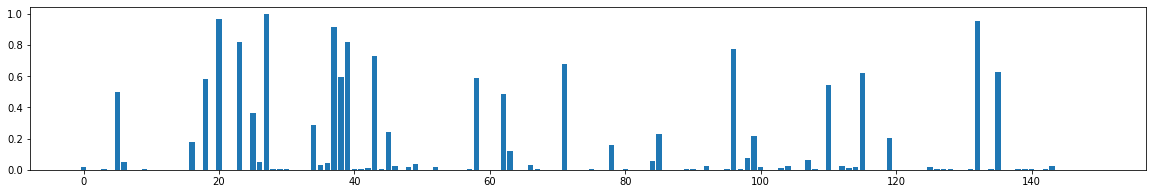

In [11]:
label = 8
plt.rcParams["figure.figsize"] = (20,3)
plt.bar(range(150), np.mean(activations_by_class[label], axis=0))